# Assignment 2 (MLSP2025)
## Suvam Dey [24290]

### Question 2:


In [1]:
import os
import numpy as np
from PIL import Image
import re
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,  confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt

Defining PCA and LDA classes for further use.

In [2]:
class PCA_cust:
    def __init__(self,K):
        self.eigvecs = None
        self.K=K
    
    def fit(self, x):
        x = x - np.mean(x, axis=0)  # Center the data
        N = len(x)
        
        # Calculate the covariance matrix
        cov = x @ x.T / N
        
        # Calculate the eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(cov)
        
        # Sort the eigenvectors by decreasing eigenvalues
        idx = np.argsort(np.abs(eigvals))[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        
        # Select the first (largest) K eigenvectors
        eigvecs = eigvecs[:, :self.K]
        eigvecs = x.T@eigvecs/np.sqrt(N*eigvals[:self.K])
        # Store eigenvectors
        self.eigvecs = eigvecs
        
    def predict(self, x):
        if self.eigvecs is None:
            raise ValueError("Model is not fitted yet.")
        
        # Project the data onto the eigenvectors
        x_projected = np.dot(x, self.eigvecs)
        return x_projected



class LDA_cust:
    def __init__(self):
        self.w = None  # Linear discriminant vector
        self.thres = 0

    def fit(self, x, y):
        idx_1 = np.argwhere(y == 1)
        idx_0 = np.argwhere(y == 0)

        # Compute class means
        m1 = np.mean(x[idx_1], axis=0)
        m0 = np.mean(x[idx_0], axis=0)

        # Compute between-class scatter matrix
        # Sb = np.outer(m1 - m0, m1 - m0)
        Sb = (m1-m0).T@(m1-m0)

        # Compute total scatter matrix
        St = np.cov(x.T)

        # Compute within-class scatter matrix
        Sw = St - Sb

        # Solve the generalized eigenvalue problem
        eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(Sw) @ Sb)
        self.J=np.linalg.inv(Sw) @ Sb
        # Select the eigenvector with the largest eigenvalue
        idx = np.argmax(np.abs(eigvals))
        
        self.w = eigvecs[:, idx]
        x_lda = self.predict(x)
        # self.J= (self.w.T@Sb@self.w)/(self.w.T@Sw@self.w)
        # Find the optimal threshold
        self.thres = self.find_optimal_threshold(x_lda, y)

    def predict(self, x):
        if self.w is None:
            raise ValueError("Model is not fitted yet.")
        
        return self.w.T @ x.T  # Project data onto LDA direction
    def find_optimal_threshold(self, x_lda, y):
        thresholds = np.linspace(np.min(x_lda), np.max(x_lda), 1000)
        best_acc = 0
        best_thres = thresholds[0]

        for thres in thresholds:
            y_pred = (x_lda >= thres).astype(int)
            acc = np.mean(y_pred == y)
            if acc > best_acc:
                best_acc = acc
                best_thres = thres

        return best_thres

Reading the data from the file and splitting it into training and testing data.

In [3]:

# Define paths
DATA_DIR = "Q2/Data/emotion_classification"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMAGE_SIZE = (100, 100)  # Image is resized to 100x100 pixels

def extract_label_from_filename(filename):
    match = re.search(r'\.(happy|sad)\.gif$', filename)
    return match.group(1) if match else None  # Extract the emotion

def load_data(directory):
    X, y = [], []

    for img_name in tqdm(os.listdir(directory), desc=f"Loading images from {directory}"):
        img_path = os.path.join(directory, img_name)
        
        # Extract label from filename
        label = extract_label_from_filename(img_name)
        if label is None:
            continue  # Skip files that don't match the pattern

        try:
            # Open image using PIL and convert to grayscale
            img = Image.open(img_path).convert("L")  # "L" mode for grayscale
            img = img.resize(IMAGE_SIZE)  # Resize to 100x100
            
            # Convert to NumPy array and flatten to (10000,)
            X.append(np.array(img).flatten())
            y.append(label)
        except Exception as e:
            print(f"Warning: Could not process {img_path}. Error: {e}")
            continue  # Skip unreadable images

    return np.array(X), np.array(y)


In [4]:

# Load training and testing data
X_train, y_train = load_data(TRAIN_DIR)
X_test, y_test = load_data(TEST_DIR)

# Encode labels (happy -> 0, sad -> 1)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Apply PCA for dimensionality reduction
K = 10  # Choose the reduced dimension
pca = PCA_cust(K=K)
pca.fit(X_train)
X_train_pca = pca.predict(X_train)
X_test_pca = pca.predict(X_test)

# Train a linear SVM classifier
svm = SVC(kernel="linear", random_state=42)
svm.fit(X_train_pca, y_train)

# Predictions and evaluation
y_pred = svm.predict(X_test_pca)

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Loading images from Q2/Data/emotion_classification\train: 100%|██████████| 20/20 [00:00<00:00, 217.45it/s]
Loading images from Q2/Data/emotion_classification\test: 100%|██████████| 10/10 [00:00<00:00, 267.98it/s]


Classification Report:
              precision    recall  f1-score   support

       happy       1.00      0.50      0.67         6
         sad       0.57      1.00      0.73         4

    accuracy                           0.70        10
   macro avg       0.79      0.75      0.70        10
weighted avg       0.83      0.70      0.69        10

Accuracy: 0.7000


Above shows teh testing accuracy upon fitting a linear SVM model on the data.

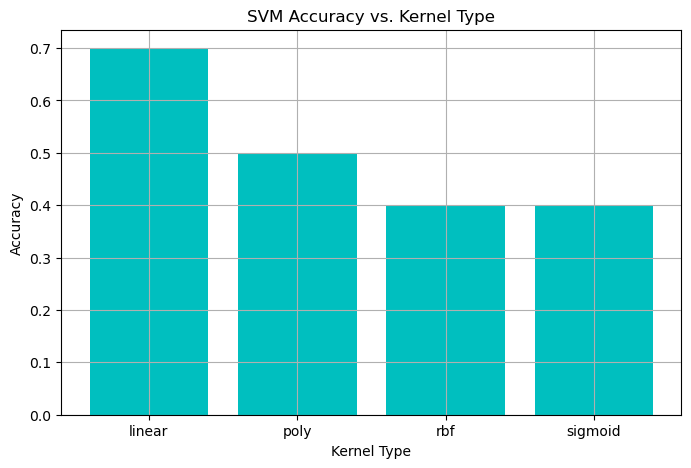

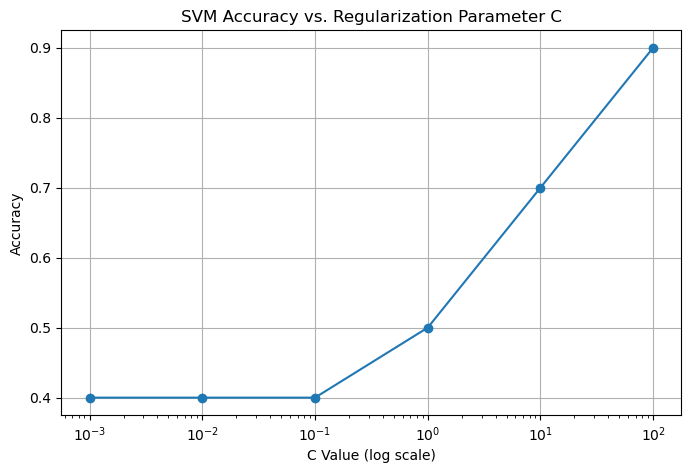

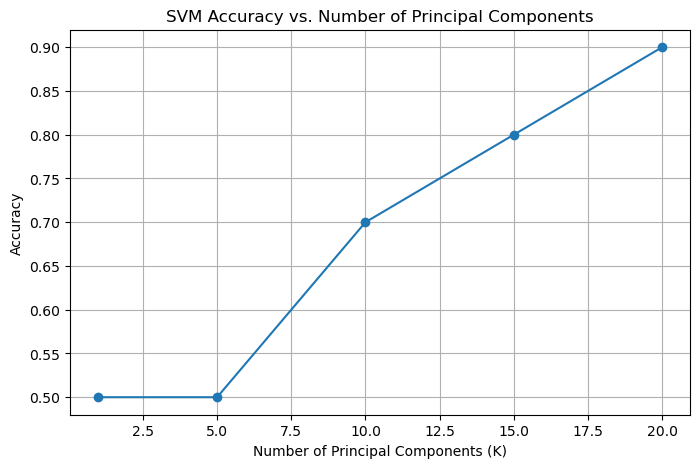

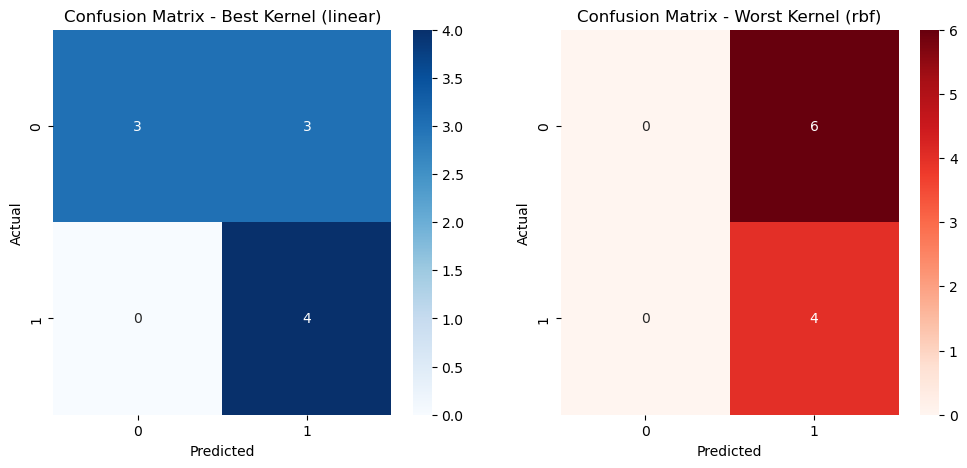

In [ ]:

kernels = ["linear", "poly", "rbf", "sigmoid"]
c_values = [0.001, 0.01, 0.1, 1, 10, 100]
k_values = [1,5, 10,15, 20]  # Different PCA dimensions

# Accuracy vs. Kernel Type
kernel_accuracies = []
for kernel in kernels:
    svm = SVC(kernel=kernel, random_state=42)
    svm.fit(X_train_pca, y_train)
    y_pred = svm.predict(X_test_pca)
    kernel_accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(8, 5))
plt.bar(kernels, kernel_accuracies, color='c')
plt.xlabel("Kernel Type")
plt.ylabel("Accuracy")
plt.title("SVM Accuracy vs. Kernel Type")
plt.grid(True)
plt.show()

# Accuracy vs. C
c_accuracies = []
for C in c_values:
    svm = SVC(kernel="poly", C=C, random_state=42)
    svm.fit(X_train_pca, y_train)
    y_pred = svm.predict(X_test_pca)
    c_accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(8, 5))
plt.semilogx(c_values, c_accuracies, marker='o', linestyle='-')
plt.xlabel("C Value (log scale)")
plt.ylabel("Accuracy")
plt.title("SVM Accuracy vs. Regularization Parameter C")
plt.grid(True)
plt.show()

# Accuracy vs. Number of Principal Components (K)
k_accuracies = []
for K in k_values:
    pca = PCA_cust(K=K)
    pca.fit(X_train)
    X_train_pca_k = pca.predict(X_train)
    X_test_pca_k = pca.predict(X_test)
    
    svm = SVC(kernel="linear", random_state=42)
    svm.fit(X_train_pca_k, y_train)
    y_pred = svm.predict(X_test_pca_k)
    k_accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(8, 5))
plt.plot(k_values, k_accuracies, marker='o', linestyle='-')
plt.xlabel("Number of Principal Components (K)")
plt.ylabel("Accuracy")
plt.title("SVM Accuracy vs. Number of Principal Components")
plt.grid(True)
plt.show()




# Confusion Matrices for Best & Worst Performing Models
best_index = np.argmax(kernel_accuracies)
worst_index = np.argmin(kernel_accuracies)

best_kernel = kernels[best_index]
worst_kernel = kernels[worst_index]

svm_best = SVC(kernel=best_kernel, random_state=42)
svm_best.fit(X_train_pca, y_train)
y_pred_best = svm_best.predict(X_test_pca)
cm_best = confusion_matrix(y_test, y_pred_best)

svm_worst = SVC(kernel=worst_kernel, random_state=42)
svm_worst.fit(X_train_pca, y_train)
y_pred_worst = svm_worst.predict(X_test_pca)
cm_worst = confusion_matrix(y_test, y_pred_worst)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title(f"Confusion Matrix - Best Kernel ({best_kernel})")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

sns.heatmap(cm_worst, annot=True, fmt="d", cmap="Reds", ax=ax[1])
ax[1].set_title(f"Confusion Matrix - Worst Kernel ({worst_kernel})")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.show()


In the above figures,

- Figure 1 plots the accuracy of SVM models for different kernels chosen, keeping all other hyperparameters fixed to defaults. The best testing accuracy is obtained in the case of **linear** kernel (70%).
- Figure 2 plots the accuracy of SVM models for different values of C, keeping all other hyperparameters fixed to defaults, kernel was chosen to be **polynomial**, since this illustrated the effect of C. Increasing C appeared to increase the testing accuracy (upto to 90%). This however, may be due to the limited number of test data points.
- Figure 3 plots the SVM accuracy vs the number of principal components used for the PCA. The best testing accuracy is obtained when 20 principal components are used (90%). This is expected, since the maximum non zero principal components is 20.
- Figure 4 plots the confusion matrices for the best and worst SVM kernels.

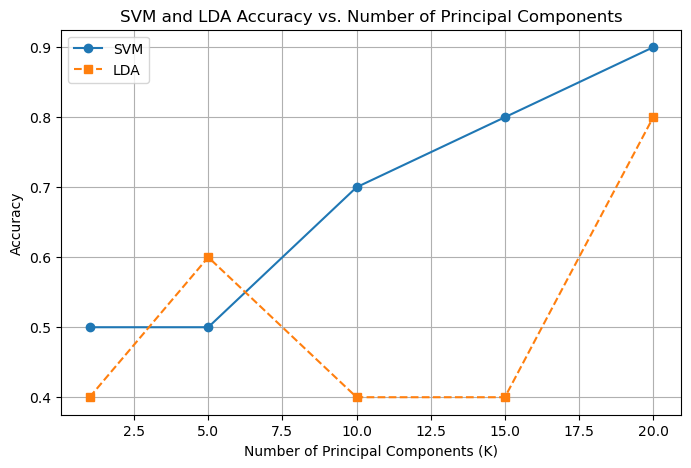

In [ ]:

k_accuracies_svm = []
k_accuracies_lda = []
for K in k_values:
    pca = PCA_cust(K=K)
    pca.fit(X_train)
    X_train_pca_k = pca.predict(X_train)
    X_test_pca_k = pca.predict(X_test)
    
    # SVM
    svm = SVC(kernel="linear", random_state=42)
    svm.fit(X_train_pca_k, y_train)
    y_pred_svm = svm.predict(X_test_pca_k)
    k_accuracies_svm.append(accuracy_score(y_test, y_pred_svm))
    
    # LDA
    lda = LDA_cust()
    lda.fit(X_train_pca_k, y_train)
    y_pred_lda = (lda.predict(X_test_pca_k) >= lda.thres).astype(int)
    k_accuracies_lda.append(accuracy_score(y_test, y_pred_lda))

plt.figure(figsize=(8, 5))
plt.plot(k_values, k_accuracies_svm, marker='o', linestyle='-', label='SVM')
plt.plot(k_values, k_accuracies_lda, marker='s', linestyle='--', label='LDA')
plt.xlabel("Number of Principal Components (K)")
plt.ylabel("Accuracy")
plt.title("SVM and LDA Accuracy vs. Number of Principal Components")
plt.legend()
plt.grid(True)
plt.show()


This figure plots the accuracy for different number of Principal Components, for both SVM and LDA models. For both, the best accuracy is obtained when 20 principal components are used, but the best accuracy using LDA is 80%, while for SVM is 90%, indicating SVM is a better model to choose in this case.

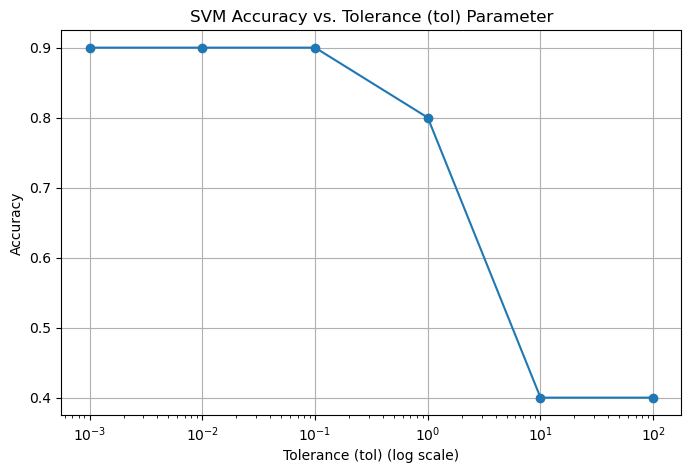

In [ ]:

# Define different tolerance values to experiment with
tol_values = [0.001, 0.01, 0.1, 1, 10, 100]  # Different tolerance levels

# Accuracy vs. tol
accuracy_tol = []
for tol in tol_values:
    svm = SVC(kernel="poly", C=100, tol=tol, random_state=42)  # Using RBF kernel as an example
    svm.fit(X_train_pca, y_train)
    y_pred = svm.predict(X_test_pca)
    accuracy_tol.append(accuracy_score(y_test, y_pred))

# Plot the accuracy vs. tol
plt.figure(figsize=(8, 5))
plt.semilogx(tol_values, accuracy_tol, marker='o', linestyle='-')
plt.xlabel("Tolerance (tol) (log scale)")
plt.ylabel("Accuracy")
plt.title("SVM Accuracy vs. Tolerance (tol) Parameter")
plt.grid(True)
plt.show()


This figure plots the effect on accuracy upon varying the tol parameter for the SVM model (chosen with polynomial kernel and 20 PCA components). The accuracy reduces with increase in epsilon (tolerance).